In [1]:
import pandas as pd
import numpy as np
from validation import cross_val, Preprocessing, cross_gen #custom lib
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import math
from os import cpu_count
pd.options.display.max_columns = None

In [2]:
n_jobs = max(cpu_count()-1, 1)

In [114]:
train = pd.read_csv('train_cleaned.csv', sep='\t')
test = pd.read_csv('test_cleaned.csv', sep='\t')

In [95]:
#train = pd.read_csv('train.csv', sep='\t').drop("Unnamed: 0",axis=1)
#test = pd.read_csv('test.csv', sep='\t').drop("Unnamed: 0",axis=1)

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
rfc = RandomForestClassifier(random_state=42, n_jobs=n_jobs)#, oob_score=True

In [115]:
X = train.drop(['0'], axis=1)
y = train['0']

In [7]:
cv_score = np.mean(cross_val_score(rfc, X, y, scoring='roc_auc',n_jobs=n_jobs))

In [8]:
print("Pure RF with no data preprocessing:", cv_score)

Pure RF with no data preprocessing: 0.6597779128921988


In [9]:
print("Pure RF with no data preprocessing:", cv_score)

Pure RF with no data preprocessing: 0.6597779128921988


# Hold out validation

In [116]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.12, random_state=42)

In [117]:
cv_score_val = np.mean(cross_val_score(rfc, X_train, y_train, scoring='roc_auc',n_jobs=n_jobs))

In [118]:
print("Pure RF with train_split and no data preprocessing:", cv_score_val)

Pure RF with train_split and no data preprocessing: 0.6601739769210956


In [119]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=3,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [120]:
y_holdout_pred = rfc.predict_proba(X_dev)

In [121]:
y_holdout_pred[:, 1]

array([0.6, 0. , 0.1, ..., 0.1, 0.3, 0.5])

In [122]:
roc_auc_score(y_dev,y_holdout_pred[:, 1])#0.673341515524867

0.673341515524867

# Cross-validation

In [123]:
skf = StratifiedKFold(shuffle=True, random_state=42)

In [124]:
parameters = {'n_estimators':[150],'max_features': [13,15,20], 'min_samples_leaf': [1, 7], 'max_depth': [20,25]}
rfc_tuned = RandomForestClassifier( random_state=42, n_jobs=-1)
gcv = GridSearchCV(rfc, parameters, n_jobs=n_jobs, cv=skf, verbose=1, scoring='roc_auc')
gcv.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:  2.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=3,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'n_estimators': [150], 'max_features': [13, 15, 20], 'min_samples_leaf': [1, 7], 'max_depth': [20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [138]:
gcv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=13, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=3,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [139]:
gcv.best_score_

0.7211786120184293

In [140]:
best_dt = gcv.best_estimator_

In [141]:
y_pred_best = best_dt.predict_proba(X_dev)

In [142]:
roc_auc_score(y_dev,y_holdout_pred[:, 1]) #0.736330981

0.673341515524867

In [143]:
roc_auc_score(y_dev,y_pred_best[:, 1]) #0.737981617413134

0.737981617413134

In [144]:
X_test = test.drop(['0'], axis=1)
y_test = test['0']

In [146]:
prediction =best_dt.predict_proba(X_test)

In [147]:
test_index = pd.read_csv('test.csv', sep='\t')
test_index = test_index['Unnamed: 0']

In [148]:
submition = pd.DataFrame({'_ID_': test_index, '_VAL_': np.zeros_like(test_index)})
submition['_VAL_'] = prediction[:,1]
submition.to_csv('submission_rf.csv', index=False)

# LB submit 0.74140859

# Preprocessing 1: del all features with 0 importance

In [47]:
importances = best_dt.feature_importances_ 
indices = np.argsort(importances) [::-1] 
feat_labels = X_train.columns[:]

In [49]:
del_features = {}
i=0
for f in range(X_train.shape[1]):
    if importances[indices[f]] == 0.:
        del_features[feat_labels[indices[f]]] = importances[indices[f]]
    
    #print("%2d) % -" ,indices[f])
    #print(X_train.iloc[:,indices[0]])

In [50]:
%matplotlib inline
from matplotlib import pyplot as plt

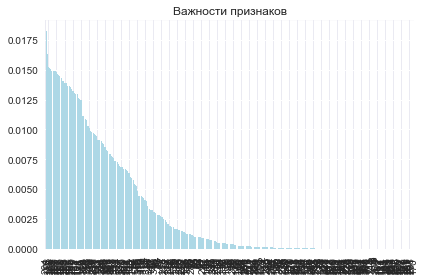

In [51]:
plt.title('Baжнocти признаков') 
plt.bar(range(X_train.shape[1]), importances[indices], color= 'lightblue', align= 'center')
plt.xticks(range(X_train.shape[1]),feat_labels[indices],rotation=90)
plt.xlim([- 1, X_train.shape[1]])
plt.tight_layout() 
plt.show() 

In [52]:
train_del_features = train.copy()
test_del_features = test.copy()

In [53]:
for i in del_features:
    del train_del_features[i]
    del test_del_features[i]

In [54]:
rfc_del = RandomForestClassifier(random_state=42, n_jobs=n_jobs)#, oob_score=True

In [79]:
X = train_del_features.drop(['0'], axis=1)
y = train_del_features['0']

In [56]:
cv_score_prep_1 = np.mean(cross_val_score(rfc_del, X, y, scoring='roc_auc',n_jobs=n_jobs))

In [57]:
print("Pure RF with preprocessing 1:", cv_score_prep_1)

Pure RF with preprocessing 1: 0.6634657744999553


# Hold out validation

In [63]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.12, random_state=42)

In [64]:
cv_score_val = np.mean(cross_val_score(rfc, X_train, y_train, scoring='roc_auc',n_jobs=n_jobs))

In [65]:
print("Pure RF with train_split and no data preprocessing:", cv_score_val)

Pure RF with train_split and no data preprocessing: 0.662356633647743


In [66]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=3,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [67]:
y_holdout_pred = rfc.predict_proba(X_dev)

In [68]:
y_holdout_pred[:, 1]

array([0.2, 0.2, 0.1, ..., 0. , 0.1, 0.1])

In [69]:
roc_auc_score(y_dev,y_holdout_pred[:, 1])

0.6635444454435553

# Cross-validation

In [80]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.12, random_state=42)

In [81]:
skf = StratifiedKFold(shuffle=True, random_state=42)

In [84]:
X_train.shape

(26840, 276)

In [85]:
parameters = {'n_estimators':[150],'max_features': [13,15,20], 'min_samples_leaf': [1, 7], 'max_depth': [20,25]}
rfc_tuned = RandomForestClassifier( random_state=42, n_jobs=n_jobs)
gcv = GridSearchCV(rfc, parameters, n_jobs=n_jobs, cv=skf, verbose=1, scoring='roc_auc')
gcv.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed:  3.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=3,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'n_estimators': [150], 'max_features': [13, 15, 20], 'min_samples_leaf': [1, 7], 'max_depth': [20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [86]:
gcv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=13, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=3,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [87]:
gcv.best_score_

0.7205030743770914

In [88]:
best_dt = gcv.best_estimator_

In [89]:
y_pred_best = best_dt.predict_proba(X_dev)

In [90]:
roc_auc_score(y_dev,y_holdout_pred[:, 1]) #0.736330981

0.6635444454435553

In [92]:
roc_auc_score(y_dev,y_pred_best[:, 1]) #0.736330981

0.7351194279196779

# Preprocessing 1: del all features with 0 importance

In [35]:
importances = best_dt.feature_importances_ 
indices = np.argsort(importances) [::-1] 
feat_labels = X_train.columns[:]

In [36]:
del_features = {}
i=0
for f in range(X_train.shape[1]):
    if importances[indices[f]] == 0.:
        del_features[feat_labels[indices[f]]] = importances[indices[f]]
    
    #print("%2d) % -" ,indices[f])
    #print(X_train.iloc[:,indices[0]])

In [37]:
%matplotlib inline
from matplotlib import pyplot as plt

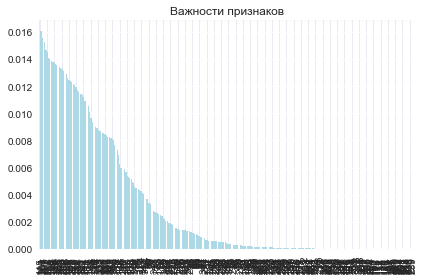

In [38]:
plt.title('Baжнocти признаков') 
plt.bar(range(X_train.shape[1]), importances[indices], color= 'lightblue', align= 'center')
plt.xticks(range(X_train.shape[1]),feat_labels[indices],rotation=90)
plt.xlim([- 1, X_train.shape[1]])
plt.tight_layout() 
plt.show() 

In [40]:
train_del_features = train.copy()
test_del_features = test.copy()

In [42]:
for i in del_features:
    del train_del_features[i]
    del test_del_features[i]

In [42]:
rfc = RandomForestClassifier(random_state=42, n_jobs=n_jobs)#, oob_score=True

In [43]:
X = train_del_features.drop(['0'], axis=1)
y = train_del_features['0']

In [45]:
cv_score_p1 = np.mean(cross_val_score(rfc, X, y, scoring='roc_auc',n_jobs=n_jobs))

In [46]:
print("Pure RF with preprocessing 1:", cv_score_p1)

Pure RF with preprocessing 1: 0.6634657744999553


In [40]:
X_train_p1, X_dev_p1, y_train_p1, y_dev_p1 = train_test_split(X, y, test_size=0.12, random_state=42)

In [41]:
cv_score_val_p1 = np.mean(cross_val_score(rfc_uf, X_train_p1, y_train_p1, scoring='roc_auc',n_jobs=n_jobs))

NameError: name 'rfc_uf' is not defined

In [114]:
print("Pure RF with train_split and data preprocessing 1:", cv_score_val_p1)

NameError: name 'cv_score_val_p1' is not defined

In [20]:
print("Pure RF with train_split and no data preprocessing:", cv_score_val)

Pure RF with train_split and no data preprocessing: 0.6601739769210956


In [60]:
rfc_uf.fit(X_train_p1, y_train_p1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=3,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [61]:
baseline_uf = rfc_uf.predict(X_dev_p1)

In [62]:
smape_fast(y_dev_p1,baseline_uf)

35.79234972677595

In [63]:
smape_fast(y_dev,baseline)

34.53551912568306

In [ ]:
submission_p2 = pd.DataFrame({'_ID_': test.index})
val_p2 = pd.DataFrame(predict, columns=['_VAL_'])
submission_p2 = pd.concat([submission_p2, val_p2],axis=1)
submission_p2.to_csv('submission_p2.csv', sep=',', encoding='utf-8',index=False)

# Params tunning 

In [95]:
X_dev_p1.shape

(3660, 271)

In [91]:
gcv_p1= None

In [96]:
parameters = {'n_estimators':[75],'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rfc_tuned = RandomForestClassifier( random_state=42, n_jobs=-1)
gcv_p1 = GridSearchCV(rfc_tuned, parameters, n_jobs=-1, cv=skf, verbose=1, scoring='roc_auc')
gcv_p1.fit(X_train_p1, y_train_p1)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  6.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [75], 'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [97]:
gcv_p1.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [98]:
gcv_p1.best_score_

0.7222226058277501

In [105]:
gcv.best_score_

0.7230666110671657

In [99]:
best_dt_1 = gcv_p1.best_estimator_

In [100]:
y_pred_best_p1 = best_dt_1.predict(X_dev_p1)

In [101]:
smape_fast(y_dev_p1,y_pred_best_p1)

33.224043715846996

In [102]:
smape_fast(y_dev,y_pred_best)

33.278688524590166

In [104]:
smape_fast(y_dev_p1,y_pred_best_p1) - smape_fast(y_dev,y_pred_best)

-0.054644808743169904

In [107]:
submission_p1 = pd.DataFrame({'_ID_': test.index})
val_p1 = pd.DataFrame(y_pred_best_p1, columns=['_VAL_'])
submission_p1 = pd.concat([submission_p1, val_p1],axis=1)
submission_p1.to_csv('submission_p1.csv', sep=',', encoding='utf-8',index=False)

In [109]:
# Не забыть почистить тест. и запридиктить

# Validation after pr-oc 1

In [55]:
(test_del_features.shape[0]*100)/(train_del_features.shape[0]+test_del_features.shape[0])

12.017538798823054

In [56]:
X_train_p1, X_dev_p1, y_train_p1, y_dev_p1 = train_test_split(X, y, test_size=0.12, random_state=42)

In [164]:
cv_score_val_p1 = np.mean(cross_val_score(rfc, X_train_p1, y_train_p1, scoring='roc_auc',n_jobs=n_jobs))

In [114]:
print("Pure RF with train_split and data preprocessing 1:", cv_score_val_p1)

NameError: name 'cv_score_val_p1' is not defined

In [20]:
print("Pure RF with train_split and no data preprocessing:", cv_score_val)

Pure RF with train_split and no data preprocessing: 0.6601739769210956


In [60]:
rfc_uf.fit(X_train_p1, y_train_p1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=3,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [61]:
baseline_uf = rfc_uf.predict(X_dev_p1)

In [62]:
smape_fast(y_dev_p1,baseline_uf)

35.79234972677595

In [63]:
smape_fast(y_dev,baseline)

34.53551912568306

In [ ]:
submission_p2 = pd.DataFrame({'_ID_': test.index})
val_p2 = pd.DataFrame(predict, columns=['_VAL_'])
submission_p2 = pd.concat([submission_p2, val_p2],axis=1)
submission_p2.to_csv('submission_p2.csv', sep=',', encoding='utf-8',index=False)

# Params tunning 

In [95]:
X_dev_p1.shape

(3660, 271)

In [91]:
gcv_p1= None

In [96]:
parameters = {'n_estimators':[75],'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rfc_tuned = RandomForestClassifier( random_state=42, n_jobs=-1)
gcv_p1 = GridSearchCV(rfc_tuned, parameters, n_jobs=-1, cv=skf, verbose=1, scoring='roc_auc')
gcv_p1.fit(X_train_p1, y_train_p1)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  6.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [75], 'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [97]:
gcv_p1.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [98]:
gcv_p1.best_score_

0.7222226058277501

In [105]:
gcv.best_score_

0.7230666110671657

In [99]:
best_dt_1 = gcv_p1.best_estimator_

In [100]:
y_pred_best_p1 = best_dt_1.predict(X_dev_p1)

In [101]:
smape_fast(y_dev_p1,y_pred_best_p1)

33.224043715846996

In [102]:
smape_fast(y_dev,y_pred_best)

33.278688524590166

In [104]:
smape_fast(y_dev_p1,y_pred_best_p1) - smape_fast(y_dev,y_pred_best)

-0.054644808743169904

In [107]:
submission_p1 = pd.DataFrame({'_ID_': test.index})
val_p1 = pd.DataFrame(y_pred_best_p1, columns=['_VAL_'])
submission_p1 = pd.concat([submission_p1, val_p1],axis=1)
submission_p1.to_csv('submission_p1.csv', sep=',', encoding='utf-8',index=False)

In [109]:
# Не забыть почистить тест. и запридиктить

# Preprocessing 2: mean

In [50]:
X = train.drop(['0'], axis=1)
y = train['0']

In [51]:
useful_columns = [feat for feat in X.columns if len(X[feat].unique()) < 90]

In [52]:
prep = Preprocessing(useful_columns, alpha=5)

In [53]:
X_train = prep.fit_transform(X,y)

In [55]:
rfc_prep_2 = RandomForestClassifier(random_state=42, n_jobs=n_jobs)#, oob_score=True

In [56]:
cv_score_prep_2 = np.mean(cross_val_score(rfc_prep_2, X_train, y, scoring='roc_auc',n_jobs=n_jobs))

In [57]:
print("Pure RF with preprocessing 2:", cv_score_prep_2)

Pure RF with preprocessing 2: 0.6726345217094929


In [153]:
print("Pure RF with preprocessing 1:", cv_score_p1)

Pure RF with preprocessing 1: 0.6691979695041391


In [156]:
print("Pure RF with no preprocessing:", cv_score)

Pure RF with no preprocessing: 0.6597779128921988


# Validation after pr-oc 2

In [58]:
X = train.drop(['0'], axis=1)
y = train['0']

In [64]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.12, random_state=42)

In [65]:
useful_columns = [feat for feat in X.columns if len(X[feat].unique()) < 90]

In [77]:
X_train_prep_2 = prep.fit_transform(X_train,y_train)
X_dev_prep_2 = prep.transform(X_dev)

In [78]:
rfc_prep_2 = RandomForestClassifier(random_state=42, n_jobs=n_jobs)#, oob_score=True

In [79]:
cv_score_p2 = np.mean(cross_val_score(rfc_prep_2, X_train_prep_2, y_train, scoring='roc_auc',n_jobs=n_jobs))

In [80]:
print("Pure RF with preprocessing 2:", cv_score_p2)

Pure RF with preprocessing 2: 0.6609134249387908


In [175]:
print("Pure RF with preprocessing 1:", cv_score_p1)

Pure RF with preprocessing 1: 0.6691979695041391


In [176]:
print("Pure RF with no preprocessing:", cv_score)

Pure RF with no preprocessing: 0.6597779128921988


In [81]:
rfc_prep_2.fit(X_train_prep_2, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=3,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [82]:
baseline_pred_2 = rfc_prep_2.predict(X_dev_prep_2)

In [83]:
smape_fast(y_dev,baseline_pred_2)

34.91803278688524

In [185]:
smape_fast(y_dev_p1,baseline_uf)

35.79234972677595

In [186]:
smape_fast(y_dev,baseline)

34.53551912568306

# Params tunning

In [84]:
X_train_prep_2.shape

(26840, 575)

In [86]:
y_train.shape

(26840,)

In [32]:
parameters = {'n_estimators':[75],'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rfc_tuned_pred_2 = RandomForestClassifier( random_state=42, n_jobs=-1)
gcv_p2 = GridSearchCV(rfc_tuned_p2, parameters, n_jobs=-1, cv=skf, verbose=1, scoring='roc_auc')
gcv_p2.fit(X_t_p2, y_train_p2)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  5.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [75], 'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [33]:
gcv_p2.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [198]:
gcv_p2.best_score_

0.7253958210497131

In [98]:
gcv_p1.best_score_

0.7222226058277501

In [105]:
gcv.best_score_

0.7230666110671657

In [35]:
best_dt_2 = gcv_p2.best_estimator_

In [36]:
y_pred_best_p2 = best_dt_2.predict(X_d_p2)

In [37]:
smape_fast(y_dev_p2,y_pred_best_p2)

32.89617486338798

In [101]:
smape_fast(y_dev_p1,y_pred_best_p1)

33.224043715846996

In [102]:
smape_fast(y_dev,y_pred_best)

33.278688524590166

In [104]:
smape_fast(y_dev_p1,y_pred_best_p1) - smape_fast(y_dev,y_pred_best)

-0.054644808743169904

In [38]:
X_test = test.drop(['0'], axis=1)
y_test = test['0']

In [224]:
prep = Preprocessing(useful_columns, alpha=5)

In [40]:
X_train = train.drop(['0'], axis=1)
y_train = train['0']

In [41]:
X_train_prep = prep.fit_transform(X_train, y_train)
X_test_prep = prep.transform(X_test)

In [42]:
best_dt_2.fit(X_train_prep, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [43]:
predict = best_dt_2.predict(X_test_prep)

In [45]:
submission_p2 = pd.DataFrame({'_ID_': test.index})
val_p2 = pd.DataFrame(predict, columns=['_VAL_'])
submission_p2 = pd.concat([submission_p2, val_p2],axis=1)
submission_p2.to_csv('submission_p2.csv', sep=',', encoding='utf-8',index=False)

In [109]:
# Не забыть почистить тест. и запридиктить